# Сабирьянов Артур; МКР, вариант 1

In [1]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve, inv
import numpy as np
from numpy.linalg import norm
from math import pi, sin, cos
from itertools import permutations
import matplotlib.pyplot as plt

In [2]:
def f(x, y):
    return sin(pi * x) * sin(pi * y)

def laplas_f(x, y, dx, dy):
    return -1.0 * pi * pi * (dx  * sin(pi * x) * sin(pi * y) + \
            dy * sin(pi * x) * sin(pi * y))

In [3]:
N = 129
dx = 1.0
dy = 1.0
h = 1.0 / (N -1)
koef = 2 # poryadok tochnosti dlya Neimana (1 or 2)
row = []
col = []
data = []

y = np.zeros(N*N)
true_y = np.zeros(N*N)

def add_elem(r, c, d):
    row.append(r)
    col.append(c)
    data.append(d)
    

for i in range(0, N):
    for j in range(0, N):
        true_y[i*N + j] = f(i*h, j*h)
        
        if j == N - 1 and i == 0: # Neumans angle
            add_elem(i * N + j, i * N + j, -(dx+dy))
            add_elem(i * N + j, i * N + j - 1, dx)
            add_elem(i * N + j, (i+1) * N + j, dy)
            y[i] = -dx * h * dx * pi * cos(pi * i * h) * sin(pi * j * h) - \
                    dy * h * dy * pi * sin(pi * i * h) * cos(pi * j * h) + \
                    (h**2 / 2) * laplas_f(i*h, j*h, dx, dy)
            
            continue
            

            
        if j == 0: #down (D)
            add_elem(i * N + j, i * N + j, 1.0)
            y[j] = f(i*h, j*h)
            continue
            
        if i == N-1:  #right (D)
            add_elem(i * N + j, i * N + j, 1.0)
            y[i*N + j] = f(i*h, j*h)
            continue
            
        if i == 0: #left (N)
            if koef == 1:
                add_elem(i * N + j, i*N + j, -dx / h)
                add_elem(i * N + j, (i+1)*N + j, dx / h)
                y[i * N + j] = dx * pi * cos(pi * i * h) * sin(pi * j * h)
            else:
                add_elem(i * N + j, (i+1) * N + j, dx / h**2)
                add_elem(i * N + j, i * N + j, -(dx + dy) / h**2 )
                add_elem(i * N + j, i * N + j + 1, dy / (2 * h**2))
                add_elem(i * N + j, i * N + j - 1, dy /(2 * h**2))
                y[i * N + j] = laplas_f(i*h, j*h, dx, dy) / 2 + (dx * pi * cos(pi * i * h) * sin(pi * j * h)) / h
                
            continue
            
        if j == N-1: #up (N)
            if koef == 1:
                add_elem(i * N + j, i*N + j, dy / h)
                add_elem(i * N + j, i*N + j-1 , -dy / h)
                y[i * N + j] = dy * pi * sin(pi * i * h) * cos(pi * j * h) 
            else:
                add_elem(i * N + j, i * N + j,  (dx + dy) / h**2)
                add_elem(i * N + j, i * N + j - 1, -dy / h**2)
                add_elem(i * N + j, (i+1) * N + j , -dx / (2 * h**2))
                add_elem(i * N + j, (i-1) * N + j, -dx / (2 * h**2))
                y[i * N + j] = laplas_f(i*h, j*h, dx, dy) / 2 + (dy * pi * sin(pi * i * h) * cos(pi * j * h)) / h
            continue
        
        
        add_elem(i * N + j, (i+1)*N + j, dx / (h*h))
        add_elem(i * N + j, (i-1)*N + j, dx / (h*h))
        
        add_elem(i * N + j, i*N + j + 1, dy / (h*h))
        add_elem(i * N + j, i*N + j - 1, dy / (h*h))
        
        add_elem(i * N + j, i*N + j, -1.0 * (2 * dx + 2 * dy) / (h*h))
        
        y[i * N + j] = laplas_f(i*h, j*h, dx, dy)
        



matr = csr_matrix((data, (row, col)), shape=(N*N, N*N)).astype('float')

In [4]:
%%time
answer = spsolve(matr, y)

Wall time: 66.8 ms


### $C_{h}$-норма

In [5]:
norm(answer - true_y, ord=np.inf)

0.0001137097859218936

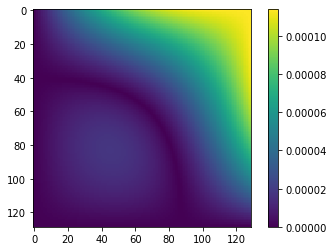

In [6]:
# график ошибки
error = np.abs(answer - true_y).reshape(N, N)
im = plt.imshow(error)
plt.colorbar()
plt.show()

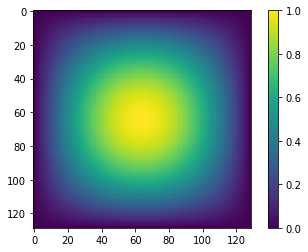

In [7]:
# график правильного решения
temp = true_y.reshape(N, N)
im = plt.imshow(temp)
plt.colorbar()
plt.show()

In [8]:
def bilin(x, y, x0, y0, h, c_x0_y0, c_x0_y1, c_x1_y0, c_x1_y1):
    return (c_x1_y1*(x - x0) / h + c_x0_y1 * (x0 + h - x) / h) * (y - y0) / h + \
        (c_x1_y0*(x - x0) / h + c_x0_y0 * (x0 + h - x) / h) * (y0 + h - y) / h

In [9]:
def integ(x0, y0, h, c_x0_y0, c_x0_y1, c_x1_y0, c_x1_y1):
    w1 = 0.2059505047
    w2 = 0.0636914142
    nu_1 = [0.1249495032, 0.4375252483, 0.4375252483]
    nu_2 = [0.7971126518, 0.1654099273, 0.0374774207]
    comb = list({(i, w1) for i in permutations(nu_1)} | {(i, w2) for i in permutations(nu_2)})
    triangles = [([x0, x0, x0+h], 
                 [y0, y0+h, y0]), 
                ([x0+h, x0, x0+h], 
                [y0, y0+h, y0+h])
                ]
    triangle_mes = h*h / 2
    result = []
    for x, y in triangles:
        triangle_res = 0
        cords = np.array([x, y, [1, 1, 1]])
        for a, w in comb:
            a = np.array(a)
            xy1 = cords.dot(a)
            xi = xy1[0]
            yi = xy1[1]
            fi = (bilin(xi, yi, x0, y0, h, c_x0_y0, c_x0_y1, c_x1_y0, c_x1_y1) - f(xi, yi))**2
            if fi > 1:
                print('!')
            triangle_res += (w * fi)
        triangle_res *= triangle_mes
        result.append(triangle_res)
    return sum(result)

### $L_{2, h}$-норма

In [10]:
l2_err = []
for i in range(N-1):
    for j in range(N-1):
        l2_err.append(integ(i*h, j*h, h, answer[i*N+j], answer[i*N + j + 1], answer[(i+1)*N + j], answer[(i+1)*N + j + 1]))

In [11]:
l2_err = np.array(l2_err)

In [12]:
np.sqrt(np.sum(l2_err))

7.513493270943649e-05